# 1. 데이터 불러오기 및 파악

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import joblib

# 데스크탑
df = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

# 노트북
# df = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

In [3]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

# 2. 문자열 데이터 정리

## 2-1. year열 I,J,K 순으로 0,1,2로 맵핑

In [4]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'].value_counts()
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})

## 2-2. 20개 지점을 5개의 지역으로 수치화

In [5]:
# # 첫 글자를 추출하여 새로운 열 생성
# df['first_letter'] = df['stn_id'].str[0]

# # 알파벳 순서에 따라 번호를 부여
# alphabet_order = {char: idx for idx, char in enumerate(sorted(df['first_letter'].unique()))}
# df['stn_id'] = df['first_letter'].map(alphabet_order)
# df.drop(columns=['first_letter'], inplace=True)

# df['stn_id'].value_counts()

In [6]:
# 나중에 df_day를 뺴놓기
df_day = df.copy()

# 첫 글자를 추출하여 새로운 열 생성
df['stn_id'] = df['stn_id'].str[0]

# 3. 결측치 처리

## 3-1.독립변수 결측치 NAN으로 변경

In [7]:
# numeric_cols = ['ws10_deg', 'ws10_ms', 're', 'ta', 'hm', 'sun10', 'ts'] # 일단 re 포함

# # -99.9 값을 NaN으로 변환
# df[numeric_cols] = df[numeric_cols].replace(-99.9, np.nan)
# df[numeric_cols].isnull().sum()

In [8]:
# -99.9 값을 NaN으로 변환
df = df.replace(-99.9, np.nan)
df = df.replace(-99, np.nan)
df.isnull().sum()

year            0
month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg     5910
ws10_ms      5826
ta           3867
re          15228
hm           3616
sun10       43910
ts          88639
vis1        22516
class       22516
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum()

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
dtype: int64

# 4. 지역별로 데이터 분할

In [10]:
df1 = df.copy()
grouped = df1.groupby('stn_id')

# 각 그룹을 별도의 데이터프레임으로 저장
df_a = grouped.get_group('A')
df_b = grouped.get_group('B')
df_c = grouped.get_group('C')
df_d = grouped.get_group('D')
df_e = grouped.get_group('E')

In [11]:
# 각 데이터프레임의 데이터 개수 확인
print("df_a 개수:", len(df_a)) # 8개의 지역
print("df_b 개수:", len(df_b)) # 4개의 지역
print("df_c 개수:", len(df_c)) # 2개의 지역
print("df_d 개수:", len(df_d)) # 3개의 지역
print("df_e 개수:", len(df_e)) # 3개의 지역

df_a 개수: 1205740
df_b 개수: 578725
df_c 개수: 290525
df_d 개수: 458363
df_e 개수: 461497


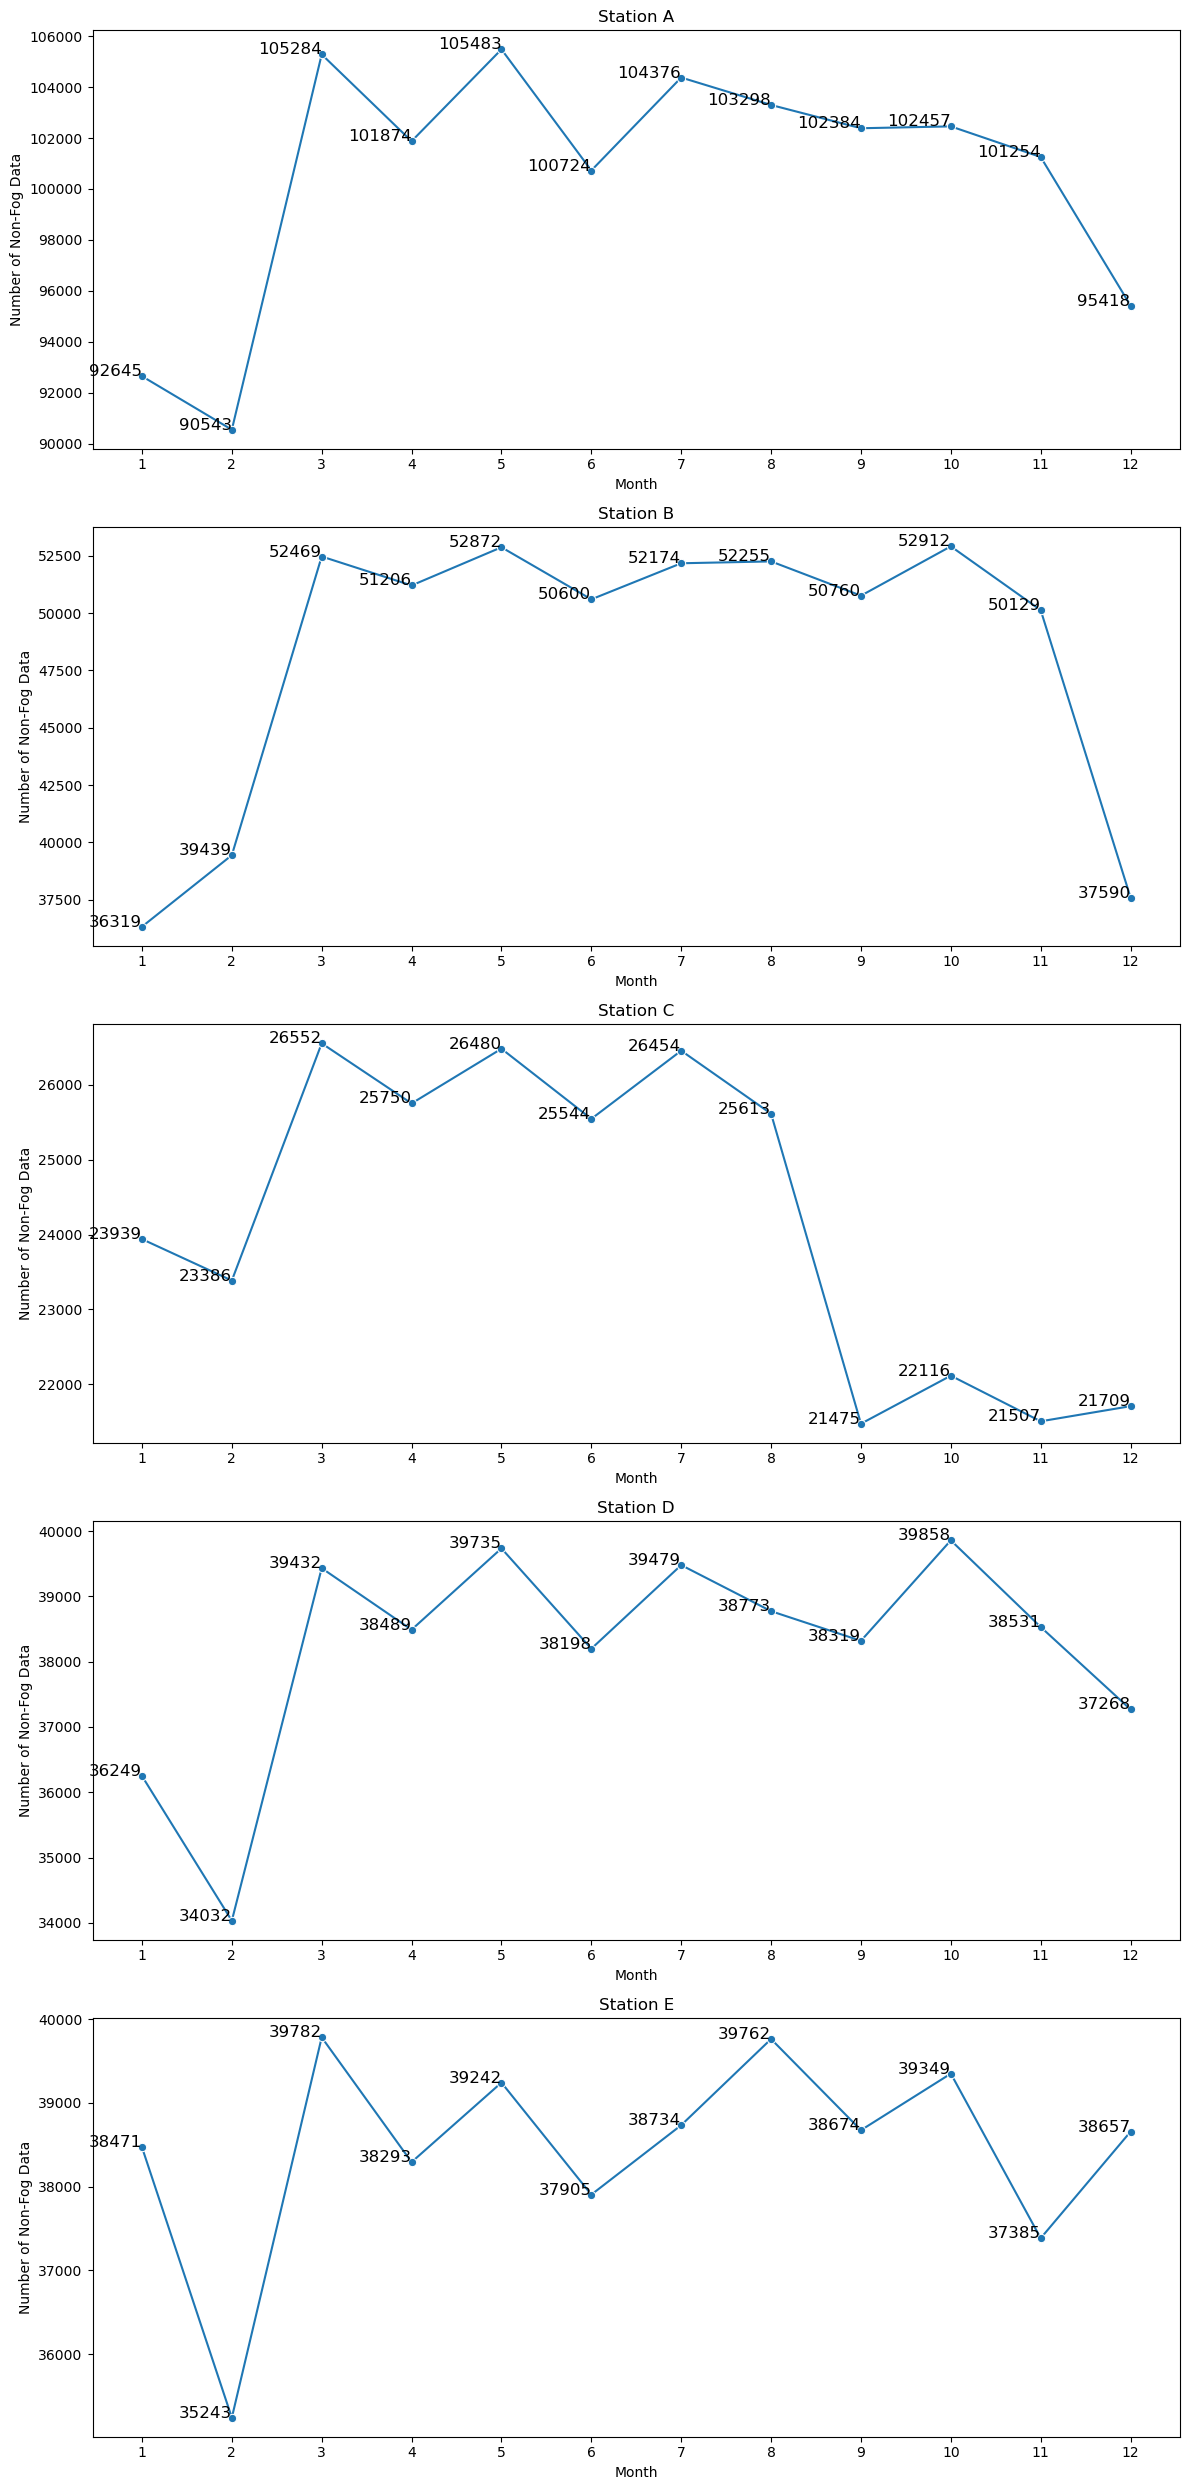

In [12]:
# 분할된 데이터프레임 리스트
dfs = [df_a, df_b, df_c, df_d, df_e]
labels = ['A', 'B', 'C', 'D', 'E']

# 플롯 설정
fig, axes = plt.subplots(5, 1, figsize=(12, 25))

for ax, df1, label in zip(axes, dfs, labels):
    # 'class' 값이 '4'가 아닌 데이터 필터링
    non_fog_data = df1[df1['class'] != '4']
    
    # 월별로 'class' 값이 '4'가 아닌 데이터 개수 세기
    monthly_non_fog_counts = non_fog_data.groupby('month').size()
    
    # 라인 플롯 그리기
    sns.lineplot(ax=ax, x=monthly_non_fog_counts.index, y=monthly_non_fog_counts.values, marker='o')
    
    # 각 점 옆에 데이터 개수 표시
    for month, count in monthly_non_fog_counts.items():
        ax.text(month, count, str(count), fontsize=12, ha='right')
    
    # 플롯 레이블 설정
    ax.set_title(f'Station {label}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Non-Fog Data')
    ax.set_xticks(range(1, 13))  # x축에 1부터 12까지 표시

# 플롯 레이아웃 조정
plt.tight_layout()
plt.show()

# 5. fog(안개 발생 유무, 1: 발생, 0 : 발생하지 않음)으로 파악

In [13]:
# df_day는 일 기준으로 데이터를 다시 만든것
# 하루중 안개가 끼면 그날은 안개가 낀날로 판단
df_day

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,0,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,0,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,0,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,0,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,0,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156456,2,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156457,2,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156458,2,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [14]:
# 'class' 열의 평균 계산하여 'class_avg' 열 추가
# class_avg는 그 날의 평균 시정거리
df_day['class_avg'] = df_day.groupby(['year', 'month', 'day', 'stn_id'])['class'].transform('mean')

# 'fog' 열(안개 여부) 추가 및 설정
# group으로 묶일 class중 4가 아닌 값의 평균이 k 이하일떄 fog에 1을 넣는 
# k=4이면 조금이라도 안개를 끼면 안개가 있는 날로 분류
k = 2
df_day['fog'] = df_day.groupby(['year', 'month', 'day', 'stn_id'])['class'].transform(lambda x: 1 if x[x != 4].mean() <= k else 0)

# 'year', 'month', 'day', 'stn_id'로 그룹화하여 'fog' 값을 합산하여 최종 fog 값 설정
df_day = df_day.groupby(['year', 'month', 'day', 'stn_id'], as_index=False).agg({'fog': 'max', 'class_avg': 'first'})

# 필요한 열만 선택
df_day = df_day[['year', 'month', 'day', 'stn_id', 'fog', 'class_avg']]

In [15]:
df_day

,year,month,day,stn_id,fog,class_avg
0,0,1,1,AA,0,4.000000
1,0,1,1,AB,0,4.000000
2,0,1,1,AC,0,4.000000
3,0,1,1,AD,0,4.000000
4,0,1,1,AE,0,4.000000
...,...,...,...,...,...,...
21915,2,12,31,DB,1,3.284722
21916,2,12,31,DC,0,4.000000
21917,2,12,31,EA,0,4.000000
21918,2,12,31,EB,1,3.284722


In [16]:
df_day['fog'].value_counts()

0    18024
1     3896
Name: fog, dtype: int64

In [17]:
# 지역 정리
df_day['stn_id_first'] = df_day['stn_id'].str[0]

# 결측치 제거
df_day = df_day.replace(-99.9, np.nan)
df_day = df_day.replace(-99, np.nan)
df_day = df_day.dropna()

In [18]:
df_day

,year,month,day,stn_id,fog,class_avg,stn_id_first
0,0,1,1,AA,0,4.000000,A
1,0,1,1,AB,0,4.000000,A
2,0,1,1,AC,0,4.000000,A
3,0,1,1,AD,0,4.000000,A
4,0,1,1,AE,0,4.000000,A
...,...,...,...,...,...,...,...
21915,2,12,31,DB,1,3.284722,D
21916,2,12,31,DC,0,4.000000,D
21917,2,12,31,EA,0,4.000000,E
21918,2,12,31,EB,1,3.284722,E


In [19]:
df2 = df_day.copy()
grouped = df2.groupby('stn_id_first')

# 각 그룹을 별도의 데이터프레임으로 저장
df_day_a = grouped.get_group('A')
df_day_b = grouped.get_group('B')
df_day_c = grouped.get_group('C')
df_day_d = grouped.get_group('D')
df_day_e = grouped.get_group('E')

In [20]:
# 각 데이터프레임의 데이터 개수 확인
print("df_day_a 개수:", len(df_day_a)) # 8개의 지역
print("df_day_b 개수:", len(df_day_b)) # 4개의 지역
print("df_day_c 개수:", len(df_day_c)) # 2개의 지역
print("df_day_d 개수:", len(df_day_d)) # 3개의 지역
print("df_day_e 개수:", len(df_day_e)) # 3개의 지역

df_day_a 개수: 8739
df_day_b 개수: 4379
df_day_c 개수: 2192
df_day_d 개수: 3284
df_day_e 개수: 3285


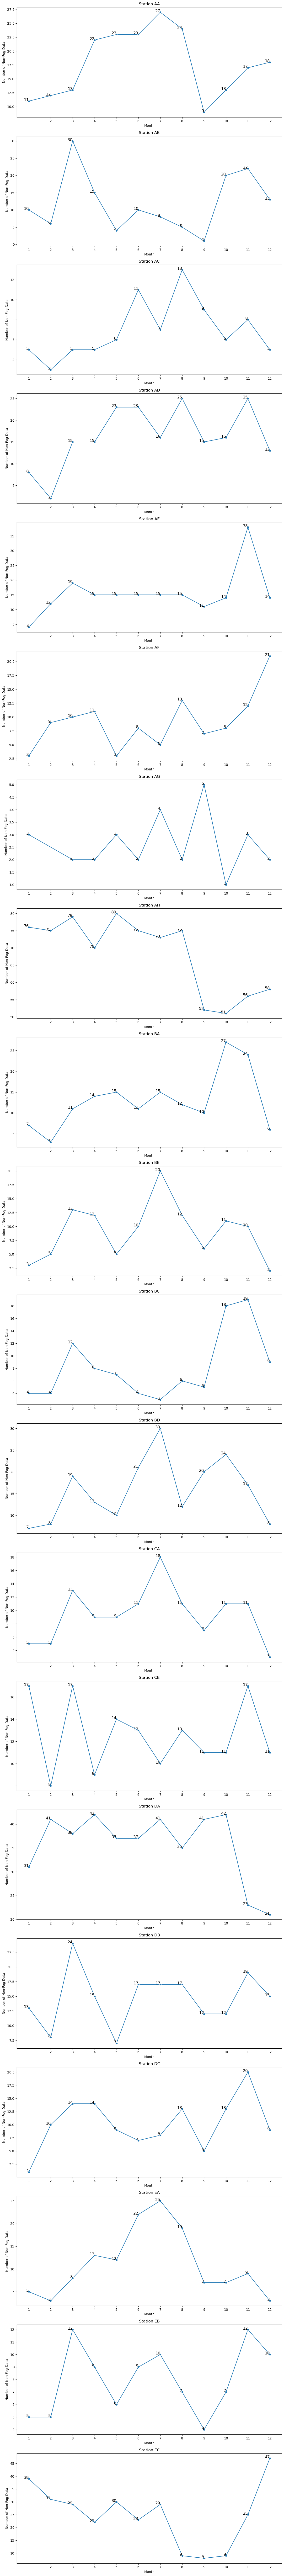

In [21]:
# 플롯 설정
fig, axes = plt.subplots(20, 1, figsize=(12, 108))

# 각 관측소별로 작업
for ax, (stn_id, group) in zip(axes, df_day.groupby('stn_id')):
    # 'class' 값이 '4'가 아닌 데이터 필터링
    non_fog_data = group[group['fog'] != 0]
    
    # 월별로 'class' 값이 '4'가 아닌 데이터 개수 세기
    monthly_non_fog_counts = non_fog_data.groupby('month').size()
    
    # 라인 플롯 그리기
    sns.lineplot(ax=ax, x=monthly_non_fog_counts.index, y=monthly_non_fog_counts.values, marker='o')
    
    # 각 점 옆에 데이터 개수 표시
    for month, count in monthly_non_fog_counts.items():
        ax.text(month, count, str(count), fontsize=12, ha='right')
    
    # 플롯 레이블 설정
    ax.set_title(f'Station {stn_id}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Non-Fog Data')
    ax.set_xticks(range(1, 13))  # x축에 1부터 12까지 표시

# 플롯 레이아웃 조정
plt.tight_layout()
plt.show()

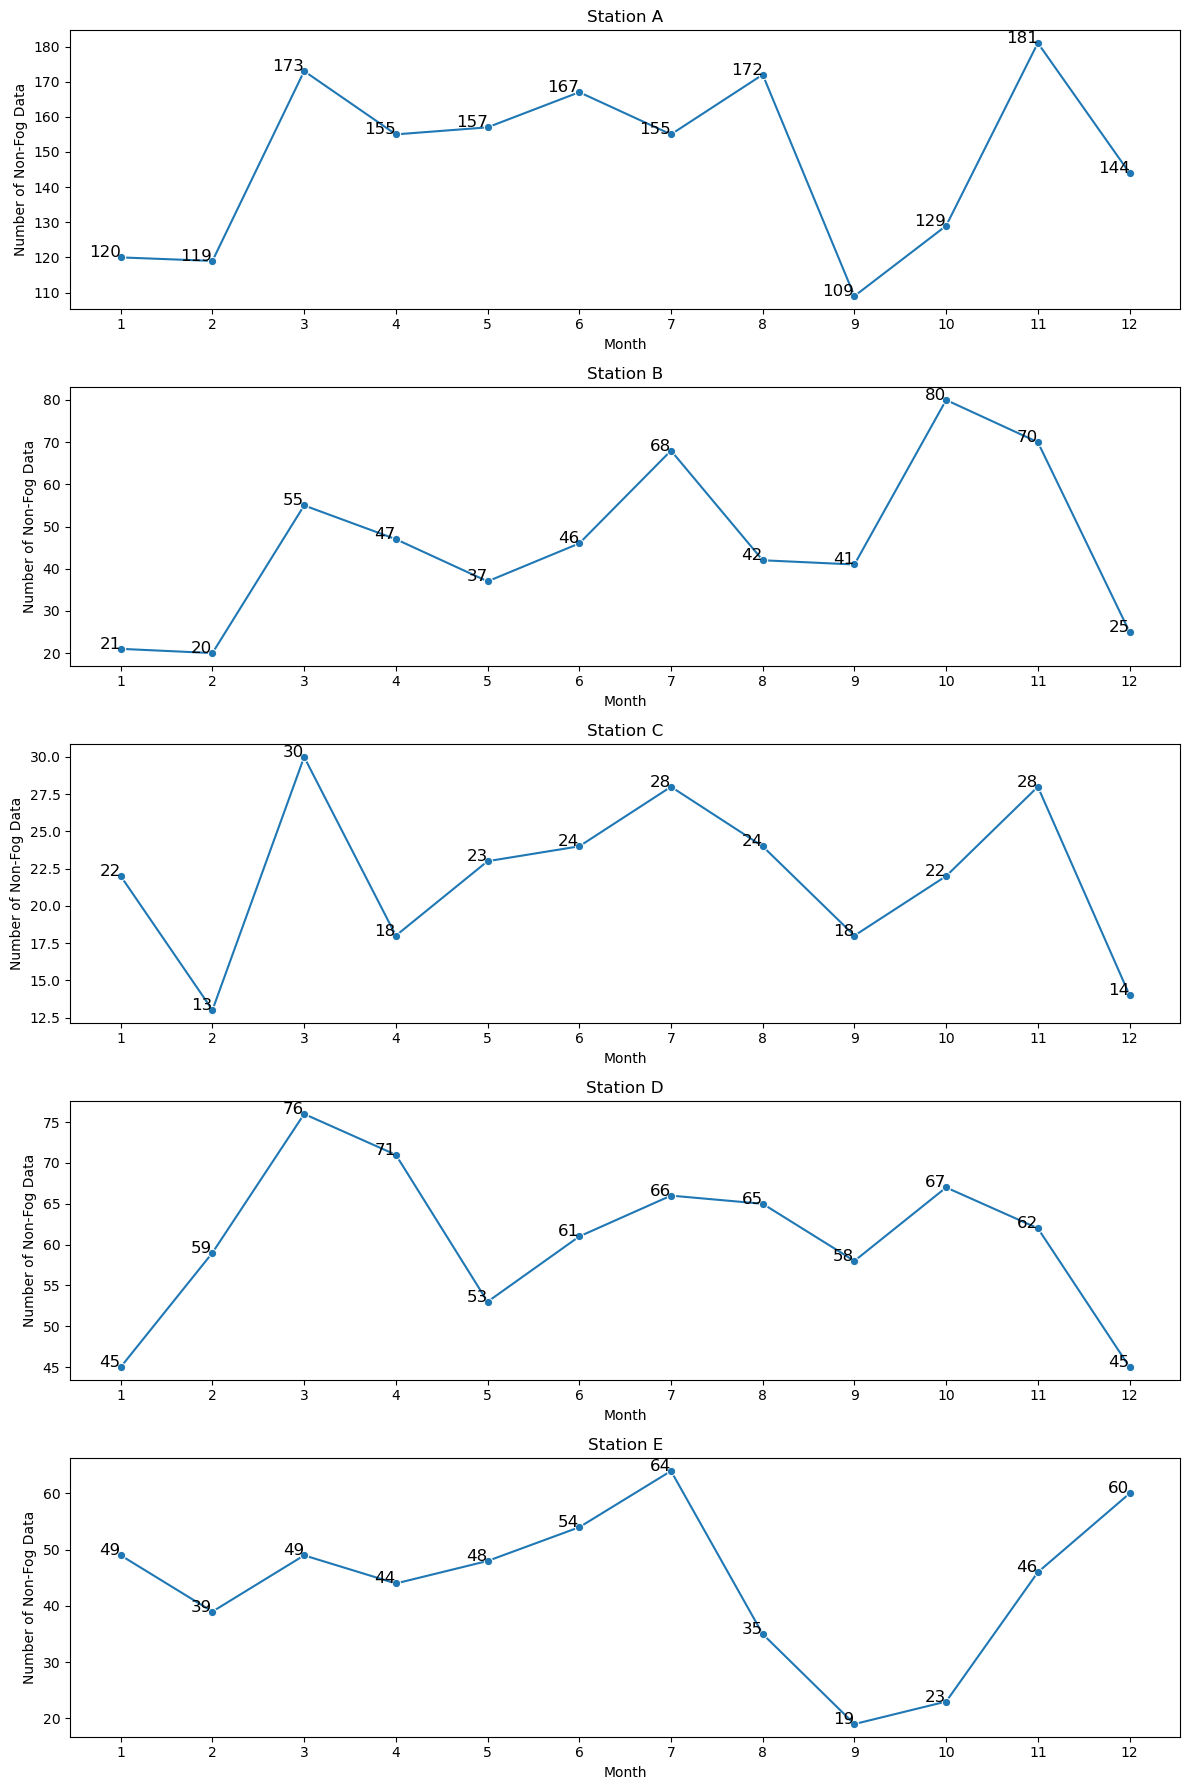

In [22]:
# 플롯 설정
fig, axes = plt.subplots(5, 1, figsize=(12, 18))

# 각 관측소별로 작업
for ax, (stn_id_first, group) in zip(axes, df_day.groupby('stn_id_first')):
    # 'class' 값이 '4'가 아닌 데이터 필터링
    non_fog_data = group[group['fog'] != 0]
    
    # 월별로 'class' 값이 '4'가 아닌 데이터 개수 세기
    monthly_non_fog_counts = non_fog_data.groupby('month').size()
    
    # 라인 플롯 그리기
    sns.lineplot(ax=ax, x=monthly_non_fog_counts.index, y=monthly_non_fog_counts.values, marker='o')
    
    # 각 점 옆에 데이터 개수 표시
    for month, count in monthly_non_fog_counts.items():
        ax.text(month, count, str(count), fontsize=12, ha='right')
    
    # 플롯 레이블 설정
    ax.set_title(f'Station {stn_id_first}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Non-Fog Data')
    ax.set_xticks(range(1, 13))  # x축에 1부터 12까지 표시

# 플롯 레이아웃 조정
plt.tight_layout()
plt.show()

# 6. 예측

In [23]:
# 안개 발생시 심한 정도 -> 결과 값이 낮을 수록 심한 안개
print(df_day_a[(df_day_a['fog'] == 1)]['class_avg'].mean()) # 8개의 지역, 8768일
print(df_day_b[(df_day_b['fog'] == 1)]['class_avg'].mean()) # 4개의 지역, 4384일
print(df_day_c[(df_day_c['fog'] == 1)]['class_avg'].mean()) # 2개의 지역, 2192일
print(df_day_d[(df_day_d['fog'] == 1)]['class_avg'].mean()) # 3개의 지역, 3288일
print(df_day_e[(df_day_e['fog'] == 1)]['class_avg'].mean()) # 3개의 지역, 3288일

0.8283512684832167
0.4774642502224026
1.6663773148148147
1.0504424795290177
0.6413390985324947


In [24]:
print(df_day_a['fog'].value_counts()) # 8개의 지역, 8768일
print(df_day_b['fog'].value_counts()) # 4개의 지역, 4384일
print(df_day_c['fog'].value_counts()) # 2개의 지역, 2192일
print(df_day_d['fog'].value_counts()) # 3개의 지역, 3288일
print(df_day_e['fog'].value_counts()) # 3개의 지역, 3288일
# df_day_a 개수: 8768일
# df_day_b 개수: 4384일
# df_day_c 개수: 2192일
# df_day_d 개수: 3288일
# df_day_e 개수: 3288일

0    6958
1    1781
Name: fog, dtype: int64
0    3827
1     552
Name: fog, dtype: int64
0    1928
1     264
Name: fog, dtype: int64
0    2556
1     728
Name: fog, dtype: int64
0    2755
1     530
Name: fog, dtype: int64


**추론 예상**

**1. A : 내륙(8개의 지역, 8768일)**
1) 관측 장소가 많음
2) 안개가 관측된 날에 비해 현저히 적음

**2. D : 산간(3개의 지역, 3288일)**
1) 안개가 가장 많은 곳은 대관령으로 한 해 평균 127.3일에 달한다.(1년의 1/3이 안개)
2) 근데 데이터 비율이 그럼

**3. 서해, 동해, 남해 남았는데**
1) 동해, 남해는 안개 발생요소나 특징이 비슷함
2) 서해는 발생도 비교적 많고 3~7월에 안개 발생 빈도가 높으며 8~10월에는 안개가 거의 발생하지 않는다. 이 중 7월에 발생빈도가 가장 높다.

**4. E : 서해(3개의 지역, 3288일)**
1. 3~7월에 안개 발생 빈도가 높으며 8~10월에는 안개가 거의 발생하지 않는다.
2. 이 중 7월에 발생빈도가 가장 높다.

**5. 동해, 남해 남았는데 -> 시정거리로 느낌적으로 분류**
1. 흑산도의 경우(남해, 서해)4월에서 7월 사이에 발생 빈도가 높으며
2. 남해의 경우 시정거리가 상당히 많이 떨어지는편

**6. B : 남해(4개의 지역, 4384일)**
1. 남해의 경우 시정거리가 상당히 많이 떨어지는편

**7. C : 동해(2개의 지역, 2192일)**
1. 남아서

**예상 정리**

**A : 내륙(8개의 지역, 8768일)**
1. 관측 장소가 많음
2. 안개가 관측된 날에 비해 현저히 적음

**B : 남해(4개의 지역, 4384일)**
1. 남해의 경우 시정거리가 상당히 많이 떨어지는편

**C : 동해(2개의 지역, 2192일)**
1. 남아서

**D : 산간(3개의 지역, 3288일)**
1. 안개가 가장 많은 곳은 대관령으로 한 해 평균 127.3일에 달한다.(1년의 1/3이 안개)
2. 근데 데이터 비율이 그럼

**E : 서해(3개의 지역, 3288일)**
1. 3~7월에 안개 발생 빈도가 높으며 8~10월에는 안개가 거의 발생하지 않는다.
2. 이 중 7월에 발생빈도가 가장 높다.

# 추가자료
> 이슬점열을 만드는 코드

> 기상청 기준 : 봄(3~5월),여름(6~8월),가을(9~11월),겨울(12~익년2월)

In [ ]:
'''
import pandas as pd
import math

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    rh = relative_humidity / 100.0
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

# # 예제 데이터프레임 생성
# data = {
#     'ta': [25.0, 20.0, 15.0, 10.0, 5.0],  # 기온 (섭씨)
#     'hm': [60.0, 70.0, 80.0, 90.0, 100.0]  # 상대 습도 (%)
# }
# df = pd.DataFrame(data)

# 이슬점 계산하여 새로운 열 추가
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

# 결과 출력
print(df)
'''

"\nimport pandas as pd\nimport math\n\n# 이슬점 계산 함수\ndef calculate_dew_point(temp_celsius, relative_humidity):\n    a = 17.27\n    b = 237.7\n    rh = relative_humidity / 100.0\n    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)\n    dew_point = (b * alpha) / (a - alpha)\n    return dew_point\n\n# # 예제 데이터프레임 생성\n# data = {\n#     'ta': [25.0, 20.0, 15.0, 10.0, 5.0],  # 기온 (섭씨)\n#     'hm': [60.0, 70.0, 80.0, 90.0, 100.0]  # 상대 습도 (%)\n# }\n# df = pd.DataFrame(data)\n\n# 이슬점 계산하여 새로운 열 추가\ndf['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)\n\n# 결과 출력\nprint(df)\n"